<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/pytorch_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Introduction to PyTorch

We show some simple examples of how to use PyTorch. 
For a more detailed introduction see the free [Deep Learning With PyTorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf) book and/or the [official tutorials](https://pytorch.org/tutorials).




In [1]:
import sklearn
import scipy
import scipy.optimize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import itertools
import time
from functools import partial

import os

import numpy as np
from scipy.special import logsumexp
np.set_printoptions(precision=3)




In [33]:


import torch
import torch.nn as nn
import torchvision
print("torch version {}".format(torch.__version__))
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  print("current device {}".format(torch.cuda.current_device()))
else:
  print("Torch cannot find GPU")

def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#torch.backends.cudnn.benchmark = True

torch version 1.8.0+cu101
Tesla V100-SXM2-16GB
current device 0


# Warmup example: binary logistic regression

We will illustrate how to use PyTorch using a very simple example, namely binary logistic regresion on the Iris dataset. The log likelihood for this model is convex, so we can compute the globally optimal MLE. This makes it easy to compare to sklearn (and other implementations). We consider deep neural networks later in the tutorial.

In [7]:
# Fit the model usign sklearn

import sklearn.datasets
from sklearn.model_selection import train_test_split

iris = sklearn.datasets.load_iris()
X = iris["data"]
y = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0'
N, D = X.shape # 150, 4

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)

from sklearn.linear_model import LogisticRegression

# We set C to a large number to turn off regularization.
# We don't fit the bias term to simplify the comparison below.
log_reg = LogisticRegression(solver="lbfgs", C=1e5, fit_intercept=False)
log_reg.fit(X_train, y_train)
w_mle_sklearn = np.ravel(log_reg.coef_)
print(w_mle_sklearn)

[-4.414 -9.111  6.539 12.686]


# Automatic differentiation <a class="anchor" id="AD"></a>

 
In this section, we illustrate how to use autograd to compute the gradient of the negative log likelihood for binary logistic regression. We first compute the gradient by hand, and then use PyTorch's autograd feature. 
(See also [the JAX optimization colab](https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/supplements/opt.ipynb).)


## Computing gradients by hand


In [35]:


# Binary cross entropy
def BCE_with_logits(logits, targets):
    N = logits.shape[0]
    logits = logits.reshape(N,1)
    logits_plus = np.hstack([np.zeros((N,1)), logits]) # e^0=1
    logits_minus = np.hstack([np.zeros((N,1)), -logits])
    logp1 = -logsumexp(logits_minus, axis=1)
    logp0 = -logsumexp(logits_plus, axis=1)
    logprobs = logp1 * targets + logp0 * (1-targets)
    return -np.sum(logprobs)/N

# Compute using numpy
def sigmoid(x): return 0.5 * (np.tanh(x / 2.) + 1)

def predict_logit(weights, inputs):
    return np.dot(inputs, weights) # Already vectorized

def predict_np(weights, inputs):
    return sigmoid(predict_logit(weights, inputs))

def NLL(weights, batch):
    X, y = batch
    logits = predict_logit(weights, X)
    return BCE_with_logits(logits, y)

def NLL_grad(weights, batch):
    X, y = batch
    N = X.shape[0]
    mu = predict_np(weights, X)
    g = np.sum(np.dot(np.diag(mu - y), X), axis=0)/N
    return g



In [36]:
w_np = w_mle_sklearn
y_pred = predict_np(w_np, X_test)
loss_np = NLL(w_np, (X_test, y_test))
grad_np = NLL_grad(w_np, (X_test, y_test))
print("params {}".format(w_np))
#print("pred {}".format(y_pred))
print("loss {}".format(loss_np))
print("grad {}".format(grad_np))

params [-4.414 -9.111 6.539 12.686]
loss 0.1182400709961879
grad [-0.235 -0.122 -0.198 -0.064]


## PyTorch code

To compute the gradient using torch, we proceed as follows.

- declare all the variables that you want to take derivatives with respect to using the requires_grad=True argumnet
- define the (scalar output) objective function you want to differentiate in terms of these variables, and evaluate it at a point. This will generate a computation graph and store all the tensors.
- call objective.backward() to trigger backpropagation (chain rule) on this graph.
- extract the gradients from each variable using variable.grad field. (These will be torch tensors.)

See the example below.

In [9]:

# data. By default, numpy uses double but torch uses float
X_train_t = torch.tensor(X_train,  dtype=torch.float)
y_train_t = torch.tensor(y_train, dtype=torch.float)

X_test_t = torch.tensor(X_test, dtype=torch.float)
y_test_t = torch.tensor(y_test, dtype=torch.float)

In [17]:
# parameters
W = np.reshape(w_mle_sklearn, [D, 1]) # convert 1d vector to 2d matrix
w_torch = torch.tensor(W, requires_grad=True, dtype=torch.float)
#w_torch.requires_grad_() 


# binary logistic regression in one line of Pytorch
def predict(X, w):
  y_pred = torch.sigmoid(torch.matmul(X, w))[:,0]
  return y_pred

# This returns Nx1 probabilities
y_pred = predict(X_test_t, w_torch)

# loss function is average NLL
criterion = torch.nn.BCELoss(reduction='mean')
loss_torch = criterion(y_pred, y_test_t)
print(loss_torch)

# Backprop
loss_torch.backward()
print(w_torch.grad)

# convert to numpy. We have to "detach" the gradient tracing feature
loss_torch = loss_torch.detach().numpy()
grad_torch = w_torch.grad[:,0].detach().numpy()


tensor(0.1182, grad_fn=<BinaryCrossEntropyBackward>)
tensor([[-0.2353],
        [-0.1223],
        [-0.1976],
        [-0.0638]])


In [18]:
# Test
assert np.allclose(loss_np, loss_torch)
assert np.allclose(grad_np, grad_torch)

print("loss {}".format(loss_torch))
print("grad {}".format(grad_torch))

loss 0.11824005842208862
grad [-0.235 -0.122 -0.198 -0.064]


# Batch optimization using BFGS

We will use BFGS from PyTorch for fitting a logistic regression model, and compare to sklearn.

In [38]:
set_seed(0)
params = torch.randn((D,1), requires_grad=True)
optimizer = torch.optim.LBFGS([params], history_size=10)
    
def closure():
    optimizer.zero_grad()
    y_pred = predict(X_train_t, params)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    return loss

max_iter = 10
for i in range(max_iter):
    loss = optimizer.step(closure)
    print(loss.item())

1.9947073459625244
0.0693957731127739
0.06907698512077332
0.06907698512077332
0.06907698512077332
0.06907698512077332
0.06907698512077332
0.06907698512077332
0.06907698512077332
0.06907698512077332


In [20]:
print("parameters from sklearn {}".format(w_mle_sklearn))
print("parameters from torch {}".format(params[:,0]))

parameters from sklearn [-4.414 -9.111  6.539 12.686]
parameters from torch tensor([-4.4147, -9.1144,  6.5401, 12.6912], grad_fn=<SelectBackward>)


In [39]:

p_pred_np = predict_np(w_np, X_test)
p_pred_t = predict(X_test_t, params) 
p_pred = p_pred_t.detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(p_pred_np)
print(p_pred)



[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]


# Stochastic optimization using SGD

## DataLoader

First we need a way to get minbatches of data.

In [22]:

from torch.utils.data import DataLoader, TensorDataset

# To make things interesting, we pick a batchsize of B=33, which is not divisible by N=100
dataset = TensorDataset(X_train_t, y_train_t)
B = 33
dataloader = DataLoader(dataset, batch_size=B, shuffle=True)
print(X_train_t.shape)
print('{} examples divided into {} batches of size {}'.format(
    len(dataloader.dataset), len(dataloader), dataloader.batch_size))

for i, batch in enumerate(dataloader):
  X, y = batch
  print(X.shape)
  print(y.shape)
 

torch.Size([100, 4])
100 examples divided into 4 batches of size 33
torch.Size([33, 4])
torch.Size([33])
torch.Size([33, 4])
torch.Size([33])
torch.Size([33, 4])
torch.Size([33])
torch.Size([1, 4])
torch.Size([1])


In [23]:
datastream = iter(dataloader)
for i in range(3):
  X,y = next(datastream)
  print(y)

tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0.])
tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.])


## Vanilla SGD training loop

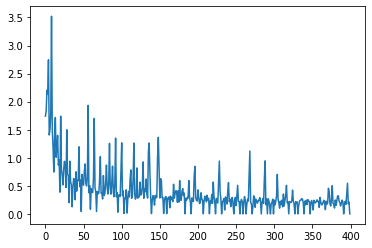

In [24]:
set_seed(0)
params = torch.randn((D,1), requires_grad=True)
nepochs = 100
nbatches = len(dataloader)
criterion = torch.nn.BCELoss(reduction='mean')
learning_rate = 1e-1
loss_trace = []

for epoch in range(nepochs):
  for b, batch in enumerate(dataloader):
    X, y =  batch

    if params.grad is not None:
      params.grad.zero_() # reset gradient to zero
    y_pred = predict(X, params)
    loss = criterion(y_pred, y)
    #print(f'epoch {epoch}, batch {b}, loss: {loss.item()}')
    loss_trace.append(loss)

    loss.backward()
    with torch.no_grad():
      params -= learning_rate * params.grad
  
  #print(f'end of epoch {epoch}, loss: {loss.item()}')
    
plt.figure()
plt.plot(loss_trace)


In [25]:
# SGD does not converge to a value that is close to the batch solver...

print("parameters from sklearn {}".format(w_mle_sklearn))
print("parameters from torch {}".format(params[:,0]))

parameters from sklearn [-4.414 -9.111 6.539 12.686]
parameters from torch tensor([-0.8046, -2.3841,  1.3471,  2.9677], grad_fn=<SelectBackward>)


In [27]:
# Predicted probabilities from SGD are very different to sklearn
# although the thresholded labels are similar
    

p_pred_np = predict_np(w_np, X_test)
p_pred_t = predict(X_test_t, params) 
p_pred = p_pred_t.detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(p_pred_np)
print(p_pred)



[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
[0.156 0.000 0.976 0.227 0.179 0.000 0.062 0.680 0.570 0.092 0.487 0.000
 0.000 0.000 0.000 0.135 0.877 0.125 0.207 0.904 0.000 0.471 0.000 0.876
 0.298 0.784 0.859 0.842 0.000 0.000 0.000 0.000 0.063 0.000 0.000 0.793
 0.094 0.000 0.000 0.000 0.803 0.107 0.119 0.000 0.000 0.100 0.396 0.553
 0.085 0.779]


In [30]:
y_pred_np = p_pred_np > 0.5
y_pred = p_pred > 0.5
print(y_pred_np)
print(y_pred)
print(np.sum(y_pred_np == y_pred)/len(y_pred))

[False False  True False False False False  True  True False  True False
 False False False False  True False False  True False  True False  True
 False  True  True  True False False False False False False False  True
 False False False False  True False False False False False False  True
 False  True]
[False False  True False False False False  True  True False False False
 False False False False  True False False  True False False False  True
 False  True  True  True False False False False False False False  True
 False False False False  True False False False False False False  True
 False  True]
0.96


## Use Torch SGD optimizer

Instead of writing our own optimizer, we can use a torch optimizer. This should give identical results.

parameters from sklearn [-4.414 -9.111 6.539 12.686]
parameters from torch tensor([-0.8046, -2.3841,  1.3471,  2.9677], grad_fn=<SelectBackward>)


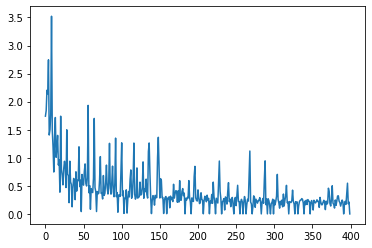

In [31]:
set_seed(0)
params = torch.randn((D,1), requires_grad=True)
nepochs = 100
nbatches = len(dataloader)
criterion = torch.nn.BCELoss(reduction='mean')
learning_rate = 1e-1
loss_trace = []

# optimizer has pointer to params, so can mutate its state
optimizer = torch.optim.SGD([params], lr=learning_rate)
    
for epoch in range(nepochs):
  for b, batch in enumerate(dataloader):
    X, y =  batch

    y_pred = predict(X, params)
    loss = criterion(y_pred, y)
    #print(f'epoch {epoch}, batch {b}, loss: {loss.item()}')
    loss_trace.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  #print(f'end of epoch {epoch}, loss: {loss.item()}')
    
plt.figure()
plt.plot(loss_trace)

print("parameters from sklearn {}".format(w_mle_sklearn))
print("parameters from torch {}".format(params[:,0]))

# Modules

We can define logistic regression as multilayer perceptron (MLP) with no hidden layers. This can be defined as a sequential neural network module. Modules hide the parameters inside each layer, which makes it easy to construct complex models, as we will see later on.


## Sequential model

In [72]:
# Make an MLP with no hidden layers

model = nn.Sequential(
    nn.Linear(D, 1, bias=False),
    nn.Sigmoid()
)
print(model)
print(model[0].weight)
print(model[0].bias)

Sequential(
  (0): Linear(in_features=4, out_features=1, bias=False)
  (1): Sigmoid()
)
Parameter containing:
tensor([[-0.1926,  0.1341, -0.0099,  0.3964]], requires_grad=True)
None


In [73]:
# We set the parameters of the MLP by hand to match sklearn.
# Torch linear layer computes X*W' + b (see https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
# where X is N*Din, so W must be Dout*Din. Here Dout=1.
print(model[0].weight.shape)
print(w_np.shape)
w = np.reshape(w_np, [-1, 1]).transpose()
print(w.shape)
model[0].weight = nn.Parameter(torch.Tensor(w))
print(model[0].weight.shape)

torch.Size([1, 4])
(4,)
(1, 4)
torch.Size([1, 4])


In [74]:

p_pred_np = predict_np(w_np, X_test)
p_pred_t = model(X_test_t).detach().numpy()[:,0] 
print(p_pred_np)
print(p_pred_t)
assert np.allclose(p_pred_np, p_pred_t)

[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]


In [65]:
# we can assign names to each layer in the sequence

from collections import OrderedDict

model = nn.Sequential(OrderedDict([
    ('linear_layer', nn.Linear(D, 1, bias=False)),
    ('output_activation', nn.Sigmoid())
  ])
)
print(model)
print(model.linear_layer)
print(model.linear_layer.weight)
print(model.output_activation)



Sequential(
  (linear_layer): Linear(in_features=4, out_features=1, bias=False)
  (output_activation): Sigmoid()
)
Linear(in_features=4, out_features=1, bias=False)
Parameter containing:
tensor([[-0.2919,  0.4298,  0.2231,  0.2423]], requires_grad=True)
Sigmoid()


In [66]:
# some layers define adjustable parameters, which can be optimized.
# we can inspect them thus:
for name, param in model.named_parameters():
  print(name, param.shape)

linear_layer.weight torch.Size([1, 4])


## Subclass the Module class

For more complex models (eg non-sequential), we can create our own subclass. We just need to define a 'forward' method that maps inputs to outputs, as we show below.

In [78]:


class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = torch.nn.Linear(D, 1, bias=False) 
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred[:,0] # (N,1) -> (N)
    
set_seed(0)
model = Model() 
w = np.reshape(w_np, [-1, 1]).transpose()
model.linear.weight = nn.Parameter(torch.Tensor(w))

p_pred_np = predict_np(w_np, X_test)
p_pred_t = model(X_test_t) # calls model.__call__ which calls model.forward()
p_pred = p_pred_t.detach().numpy()
print(p_pred_np)
print(p_pred)
assert np.allclose(p_pred_np, p_pred)



[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]


## Output layer

For binary classification problems, we can use a sigmoid as the final layer, to return probabilities. The corresponding loss is the binary cross entropy, [nn.BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)(pred_prob, true_label), where true_label is 0 or 1. Alternatively the model can return the logit score, and use [nn.BECWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)(pred_score, true_label).

For multiclass classifiction, the final layer can return the log probabilities using LogSoftmax layer, combined with the negative log likelihood loss, [nn.NLLLoss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)(pred_log_probs, true_label), where pred_log_probs is a B*C matrix (for batch size B), and true_label is a (B) vector with entries in {0,1,..C-1}.
(Note that the target labels are integers, not sparse one-hot vectors.)
Alternatively, we can just return the vector of logit scores, and use [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)(logits, true_label). The above two methods should give the same results.


In [ ]:
# code me

## SGD on a module

We can optimize the parameters of a module by passing a reference to them into the optimizer, as we show below.

[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
[0.235 0.000 0.994 0.382 0.257 0.000 0.097 0.884 0.705 0.130 0.756 0.000
 0.000 0.000 0.000 0.264 0.970 0.168 0.339 0.976 0.000 0.723 0.000 0.965
 0.567 0.934 0.945 0.961 0.000 0.000 0.000 0.000 0.094 0.000 0.000 0.917
 0.166 0.000 0.000 0.000 0.936 0.226 0.196 0.000 0.000 0.123 0.591 0.795
 0.127 0.949]


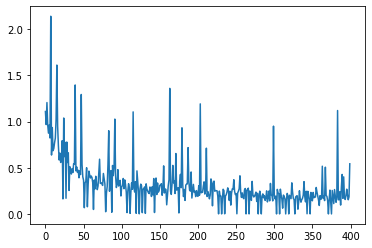

In [79]:


nepochs = 100
nbatches = len(dataloader)
criterion = torch.nn.BCELoss(reduction='mean')
learning_rate = 1e-1
loss_trace = []

set_seed(0)
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
for epoch in range(nepochs):
  for b, batch in enumerate(dataloader):
    X, y =  batch

    y_pred = model(X) # predict/ forward function
    loss = criterion(y_pred, y)
    #print(f'epoch {epoch}, batch {b}, loss: {loss.item()}')
    loss_trace.append(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  #print(f'end of epoch {epoch}, loss: {loss.item()}')
    
plt.figure()
plt.plot(loss_trace)


y_pred_np = predict_np(w_np, X_test)
y_pred_t = model(X_test_t) 
y_pred = y_pred_t.detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(y_pred_np)
print(y_pred)

## Batch optimization on a module

SGD does not match the results of sklearn. However, this is not because of the way we defined the model, it's just because SGD is a bad optimizer. Here we show that BFGS gives exactly the same results as sklearn.


In [80]:

set_seed(0)
model = Model()
optimizer = torch.optim.LBFGS(model.parameters(), history_size=10)

criterion = torch.nn.BCELoss(reduction='mean')
def closure():
    optimizer.zero_grad()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    loss.backward()
    return loss

max_iter = 10
loss_trace = []
for i in range(max_iter):
    loss = optimizer.step(closure)
    #print(loss)

y_pred_np = predict_np(w_np, X_test)
y_pred_t = model(X_test_t) 
y_pred = y_pred_t.detach().numpy()
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(y_pred_np)
print(y_pred)



[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]
[0.002 0.000 1.000 0.012 0.002 0.000 0.000 0.979 0.740 0.000 0.706 0.000
 0.000 0.000 0.000 0.001 1.000 0.000 0.009 1.000 0.000 0.650 0.000 1.000
 0.094 0.998 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.998
 0.000 0.000 0.000 0.000 0.999 0.000 0.000 0.000 0.000 0.000 0.281 0.909
 0.000 0.999]


# Our first neural network: an MLP for classifying CIFAR images

In this section, we follow Chap. 7 of the [Deep Learning With PyTorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf) book, and illustrate how to fit an MLP to a two-class version of CIFAR. (We modify the code from [here](https://github.com/deep-learning-with-pytorch/dlwpt-code/tree/master/p1ch7).)

## Get the CIFAR dataset

In [90]:
from torchvision import datasets

folder = 'data'
cifar10 = datasets.CIFAR10(folder, train=True, download=True)
cifar10_val = datasets.CIFAR10(folder, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [84]:
print(type(cifar10))
print(type(cifar10).__mro__) # module resolution order shows class hierarchy


<class 'torchvision.datasets.cifar.CIFAR10'>
(<class 'torchvision.datasets.cifar.CIFAR10'>, <class 'torchvision.datasets.vision.VisionDataset'>, <class 'torch.utils.data.dataset.Dataset'>, <class 'typing.Generic'>, <class 'object'>)


50000
<class 'PIL.Image.Image'>
<PIL.Image.Image image mode=RGB size=32x32 at 0x7F59421FED10>


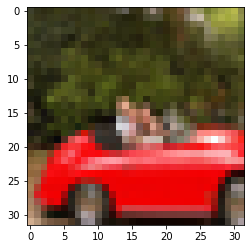

In [85]:
print(len(cifar10))
img, label = cifar10[99]
print(type(img))
print(img)
plt.imshow(img)
plt.show()


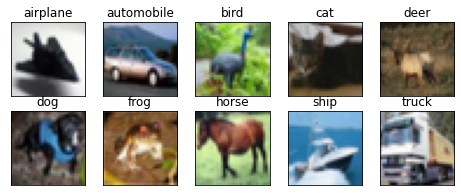

In [86]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in cifar10 if label == i)
    plt.imshow(img)
plt.show()

## Convert to tensors

In [88]:
# Now we want to convert this to a tensor
from torchvision import transforms

to_tensor = transforms.ToTensor()

img, label = cifar10[99]
img_t = to_tensor(img)
print(type(img))
#print(img.shape)
print(type(img_t))
print(img_t.shape) # channels * height * width, here channels=3 (RGB)



<class 'PIL.Image.Image'>
<class 'torch.Tensor'>
torch.Size([3, 32, 32])


In [91]:
# transform the whole dataset to tensors
cifar10 = datasets.CIFAR10(folder, train=True, download=False,
                          transform=transforms.ToTensor())

<class 'torch.Tensor'>
tensor(0.) tensor(1.)


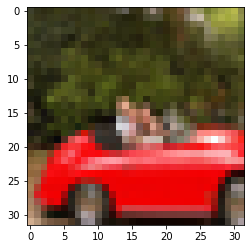

In [92]:
img, label = cifar10[99]
print(type(img))
print(img.min(), img.max()) # pixel values are rescaled to 0..1

plt.imshow(img.permute(1, 2, 0)) # matplotlib expects H*W*C
plt.show()


## Standardize the inputs

We standardize the features by  computing the mean and std of each channel, averaging across all pixels and all images. This will help optimization.

In [93]:
# we load the whole training set as a batch, of size 3*H*W*N

imgs = torch.stack([img for img, _ in cifar10], dim=3)
print(imgs.shape)


torch.Size([3, 32, 32, 50000])
tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


In [94]:
imgs_flat =  imgs.view(3, -1) # reshape by keeping first 3 channels, but flatten all others 
print(imgs_flat.shape)
mu = imgs_flat.mean(dim=1) # average over second dimension (not channel)
sigma = imgs_flat.std(dim=1)
print(mu)
print(sigma)

torch.Size([3, 51200000])
tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


In [95]:
cifar10 = datasets.CIFAR10(folder, train=True, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mu, sigma)
                          ]))

cifar10_val = datasets.CIFAR10(folder, train=False, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize(mu, sigma),
                          ]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


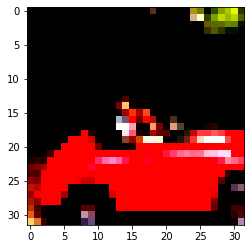

In [96]:
# rescaled data is harder to visualize
img, _ = cifar10[99]

plt.imshow(img.permute(1, 2, 0))
plt.show()


## Create two-class version of dataset

We extract data which correspond to airplane or bird.
The result object is a list of pairs.
This "acts like" an object of type torch.utilts.data.dataset.Dataset, since it implements the len() and item index methods.

In [97]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

label_map = {0: 0, 2: 1} # 0(airplane->0, 2(bird)->1
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [98]:
print(len(cifar2))
print(len(cifar2_val))


10000
2000
